# Lecture 7: When Are Instruments Strong? Understanding Stock & Yogo (2005)

We've seen in the lecture that instrument strength is determined by first stage F. 

Staiger & Stock (1997) came up with the *Rule of Thumb* that a first stage F above the value of 10 implies that the instruments should be called strong. 

Their reasoning will become clearer by the end of this notebook.

Subsequently, Stock & Yogo (2005) refined this rule and provided various critical values depending on the parameter configuration of the underlying model.

Let's investigate their argument.

## Data Generating Process (DGP)

We will restrict ourselves to the toy model of Keane & Neal (2024).

Their DGP is on page 193, summarized here:

$$
\begin{align*}
    Y_i &= \beta X_i + u_i\\
    X_i &= \pi Z_i + v_i\\
    v_i &= \rho u_i + \sqrt{1-\rho^2} \eta_i
\end{align*}
$$

where 

* $u_i \sim N(0,1)$

* $\eta_i \sim N(0,1)$

* $Z_i \sim N(0,1)$

* $\beta = 0$

* notice: $\sigma_v^2 = 1$

To be able to create data sets off the above DGP we need to know values for $\pi$ and $\rho$.

Determination of $\pi$ will follow a roundabout way. 

Recall the definition of F from lecture 6: F is the proportion of the variance of $X$ that is explained by $Z$ divided by the proportion of the variance of $X$ that is explained by $v$:

$$
F 
= N \cdot \frac{R^2}{1-R^2}
= N \cdot \frac{\text{ESS}}{\text{RSS}}
= N \cdot \frac{\text{Var}(Z\pi)}{\sigma_v^2}
= N \cdot \frac{\pi^2 \text{Var}(Z)}{\sigma_v^2}
= N \cdot \pi^2
$$

This allows us to set $\pi$ in the above DGP by changing the value of $F$, because $\pi = \sqrt{F/N}$.

* Bias of OLS $\approx \rho$ 
  (provided $\pi$ is small)

## Julia Functions 

I'm parking a bunch of functions that are needed for the simulations.


In [2]:
using Distributions, Random 

function dgp_keane_neal(; b=0, n=1000, F, rho)

    """
    Generates one sample of size n following the DGP of Keane & Neal (2024) page 193

    ### Input

    - `b`   -- structural coefficient beta (scalar)
    - `n`   -- sample size
    - `F`   -- reduced form F-stat 
    - `rho` -- degree of endogeneity

    ### Output

    - `x`   -- (n by 1) vector representing endogenous regressor
    - `y`   -- (n by 1) vector representing outcome variable
    - `z`   -- (n by 1) vector representing instrumental variable
    """

    p = sqrt(F/n)
    u = rand(Normal(0, 1), n)
    eta = rand(Normal(0, 1), n)
    z = rand(Normal(0, 1), n)
    v = rho*u + sqrt(1-rho^2)*eta
    x = p*z .+ v
    y = b*x .+ u

    return (; x, y, z)

end

dgp_keane_neal (generic function with 1 method)

In [13]:
function ols_estimator(x, y)

    """
    Implements OLS estimation of linear model with one exogenous regressor.

    ### Input

    - `x`   -- (n by 1) vector representing regressor
    - `y`   -- (n by 1) vector representing outcome variable

    ### Output

    - `bhat` --OLS estimate of beta
    - `se`   --standard error of OLS estimate
    - `t`    --t-statistic of OLS estimator
    """

        # OLS estimator
        bhat= x\y

        # standard error
        uhat = y-x*bhat
        s = uhat'uhat/length(y)
        se= sqrt(s/(x'x))

        # t-statistic (absolute value)
        t = bhat/se

        return (; bhat, se, t) # returning named tuple

end

ols_estimator (generic function with 1 method)

In [14]:
function iv_estimator(x, y, z)

    """
    Implements IV estimation of linear model with one endogenous variable, and one instrument.

    ### Input

    - `x`   -- (n by 1) vector representing endogenous regressor
    - `y`   -- (n by 1) vector representing outcome variable
    - `z`   -- (n by 1) vector representing instrumental variable

    ### Output

    - `biv`  -- IV estimate of beta
    - `se`   -- standard error of IV estimate
    - `t`    -- t-statistic of IV estimator
 
    ### Notes

    For calculation of standard error, we're using the formula on page 190 of Keane & Neal (2024)
    """

    # IV estimator
    bhat= (z'y)/(x'z)

    # standard error (using formula in Keane & Neal (2024))
    n = length(y)
    pihat = z\x         # reduced form coefficient estimate
    TSS = n*pihat^2*var(z)
    uhat = y-x*bhat
    s = uhat'*uhat/n
    se = sqrt(s/TSS)

    # t-statistic (absolute value)
    t = bhat/se
    
    return (; bhat, se, t) # returning `named tuple`

end

iv_estimator (generic function with 1 method)

In [ ]:
function simulate_distribution(; b=0, F, rho, rep=10000)

    """
    Creates finite sample distributions of 
    - IV estimator,
    - standard error of IV estimator
    - tstat of IV estimator

    How does it create finite sample distribution? It creates `rep` number of DGPs and each time
    calculates IV estimator, its standard error, and tstat.
    
    ### Input

    - `F`       -- reduced form F-stat 
    - `rho`     -- degree of endogeneity
    - `rep`     -- number of repititions/simulations run

    ### Output
    
    - `bols_dst`    -- (rep by 1) vector collecting rep simulations of OLS estimator
    - `sols_dst`    -- (rep by 1) vector collecting rep simulations of standard error of OLS estimator
    - `tols_dst`    -- (rep by 1) vector collecting rep simulations of tstat of OLS estimator
    - `biv_dst`     -- (rep by 1) vector collecting rep simulations of IV estimator
    - `siv_dst`     -- (rep by 1) vector collecting rep simulations of standard error of IV estimator
    - `tiv_dst`     -- (rep by 1) vector collecting rep simulations of tstat of IV estimator
    - `tar_dst`     -- (rep by 1) vector collecting rep simulations of AR-statistic
    """

    bols_dst = Array{Float64}(undef, rep)
    sols_dst = Array{Float64}(undef, rep)
    tols_dst = Array{Float64}(undef, rep)

    biv_dst = Array{Float64}(undef, rep)
    siv_dst = Array{Float64}(undef, rep)
    tiv_dst = Array{Float64}(undef, rep)

    ar_dst = Array{Float64}(undef, rep)
    
    for i = 1:rep

        x, y, z = dgp_keane_neal(b=b, F=F, rho=rho)

        # calculating simulated distribution for bols, seols, and tols
        bols_dst[i], sols_dst[i], tols_dst[i] = ols_estimator(x, y)

        # calculating simulated distribution for biv, seiv, and tiv
        biv_dst[i], siv_dst[i], tiv_dst[i] = iv_estimator(x, y, z)

        # calculating AR statistic
        # by regressing Y on Z
        ar_dst[i] = ols_estimator(z, y).t

    end
    
    return (; bols_dst, sols_dst, tols_dst, biv_dst, siv_dst, tiv_dst, ar_dst)

end

simulate_distribution (generic function with 1 method)

## Creating Simulated Distributions

We will explore different versions of Keane & Neal's DGP, where we vary the instrument strength and the degree of endogeneity. To frame this, we will consider the following combinations:

| DGP #   | population F    | $\rho$  | Description                                           |
|---------|-----------|---------|-------------------------------------------------------|
| 1       | 1.82      | 0.1     | weak IV, low degree of endogeneity                    |
| 2       | 2.30      | 0.1     | rule of thumb IV, low degree of endogeneity           |
| 3       | 73.75     | 0.1     | strong IV, low degree of endogeneity                  |
| 4       | 1.82      | 0.5     | weak IV, moderage degree of endogeneity               |
| 5       | 2.30      | 0.5     | rule of thumb IV, moderate degree of endogeneity      |
| 6       | 73.75     | 0.5     | strong IV, moderate degree of endogeneity             |
| 7       | 1.82      | 0.9     | weak IV, high degree of endogeneity                   |
| 8       | 2.30      | 0.9     | rule of thumb IV, high degree of endogeneity          |
| 9       | 73.75     | 0.9     | strong IV, high degree of endogeneity                 |

I will explain soon how these particular choices for F come about, and why the value of 2.30 is labelled 'rule of thumb'.

With these combinations of $F$ and $\rho$ we are now able to create data sets that are based on the above DGP.

Let's use the above Julia functions to create 10,000 samples of size 1,000 for each of the nine DGPs.

In [15]:
# let's represent these DGPs by tuples
parms_rho = (0.10, 0.50, 0.90)
parms_F = (1.82, 2.30, 73.75)

# create an object `dgps` that collects all DGPs that follow these nine parameter combinations:
dgps = [simulate_distribution(rho = rho, F = F) for rho in parms_rho, F in parms_F];

## Distribution of IV estimator

Let's start by plotting the distributions of the IV estimators for each case.

We're plotting the *standardized* IV estimator, that is, its t-statistic here. 

Why? Because we know that a well behaved t-stat should have (almost) a standard normal distribution.

What do you think? Do all of these look standard normal?

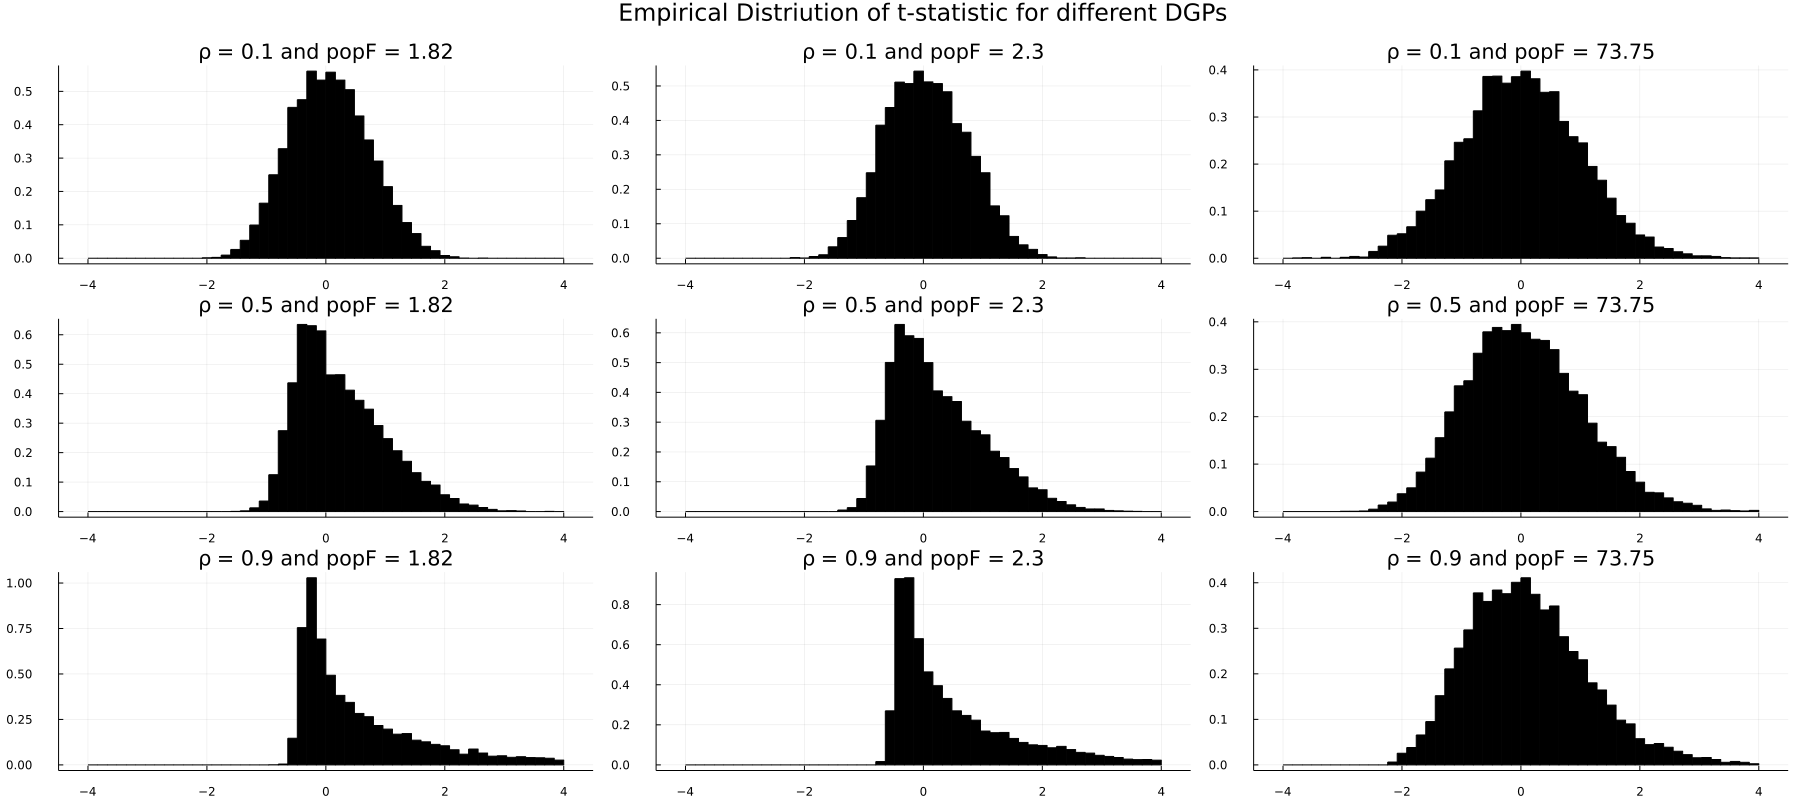

In [16]:
using Plots
using Plots.PlotMeasures: mm
Plots.theme(:wong2)

plt = plot(layout=(length(parms_F),length(parms_rho)), size = (1800, 800),
        plot_title = "Empirical Distriution of t-statistic for different DGPs")

for (i, rho) in enumerate(parms_rho)
    for (j, F) in enumerate(parms_F)
        #b, se, t = dgps[i, j]
        histogram!(plt, 
            dgps[i,j].tiv_dst,
            normalize = true, 
            subplot = length(parms_F)*(i-1)+j, 
            bins = range(-4, 4, length=51), 
            legend=false, 
            title = "\\rho = $rho and popF = $F")
    end
end

display(plt)

What do we learn from the above picture?

Recall: a well behaved distribution should be standard normal. 

The top right picture comes closest to that ideal

It's the case of low endogeneity and strong instrument

We will regard this to be our benchmark case

Relative to that benchmark, the bottom left four histograms don't look hopeful!

## Empirical Size: Stock & Yogo's Idea to Limit the Damage

We've just seen that in some scenarios, the t-stat can be very non-normal

Statistical inference based on the t-stat could thus be on shaky grounds


### Digression: Trusty t-test

When we run a t-test, we calculate
$$
t := \frac{\hat{\beta}_{IV}}{se(\hat{\beta}_{IV})}
$$

Let's say we obtain a value of $t=4.312$. What does this tell us? Well, we compare that value to the cutoff 1.96 and decide that $4.312 > 1.96$ and therefore we are sufficiently far away from zero to make the call that the true coefficient is *probably* not zero. 

For our DGP we happen to know that true $\beta = 0$, so our finding that $\beta \neq 0$ is incorrect! We understand that this can happen sometimes, in fact for a properly behaved t-stat it will happen 5\% of the time. This is the significance level, or type 1 error, or statistical size of our test

**Size = probability to reject the null hypothesis when it is correct**.

Did you notice where we used the CLT just now? Correct! by comparing the value of $t$ to the value of 1.96 which comes from the standard normal distribution!

But what if $t$ doesn't have a standard normal distribution? Then our test may be poor: while the nominal size is 5\% (the size of the test if $t$ really follows a normal distribution), the *empirical size* maybe something completely different.

Luckily we are able to simulate the empirical size. 


## Stock & Yogo's (2005) Worst Case Cutoffs

Stock and Yogo (2005) is an influential paper that still guides practitioners

Their idea: let population $F$ vary and simulate the empirical size

Declare an instrument to be strong when the empirical size isn't too bad

All the while, we fix $\rho$ at the extreme value of 1

This is Stock & Yogo's worst-case scenario

They conjecture that the weak instrument problem is amplified by $|\rho|$

In other words, by fixing $\rho =1$ we study a conservative worst-case situation

Let's study how the empirical size varies in $F$. We vary $F$ in small increments between 0 and 20, and calculate the proportion of $|t| > 1.96$ among 10,000 replications of the DGP.

But what exactly does this mean? When precisely should we declare instruments to be weak?

Short answer: when the small sample distribution of the IV estimator becomes so non-normal that we can't rely on our trusty t-test anymore!



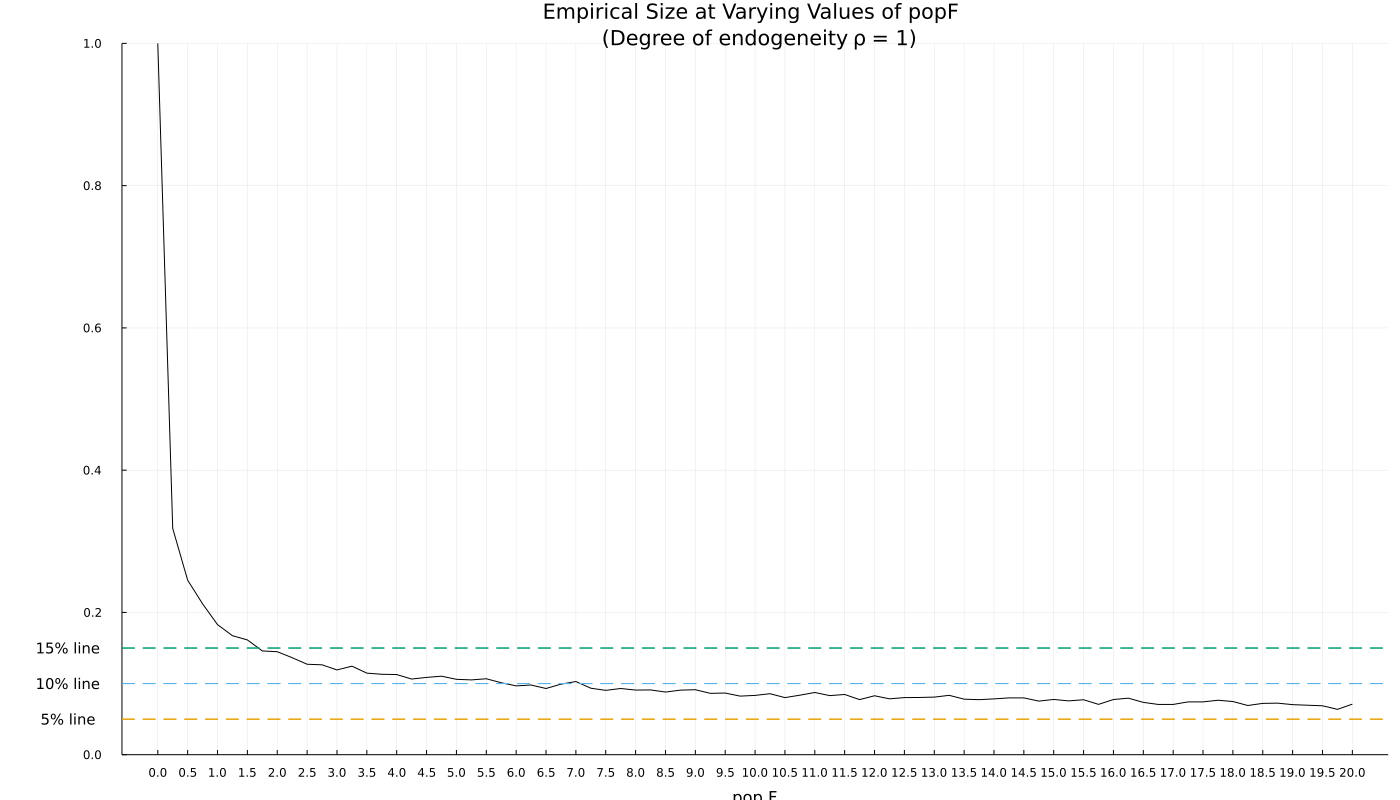

In [ ]:
using Plots
using Plots.PlotMeasures: mm
Plots.theme(:wong2)

F_range = 0:.25:20
emp_size = [mean(abs.(simulate_distribution(F=F, rho=1).tiv_dst .> 1.96)) for F in F_range]

plot(F_range, emp_size, 
    legend=false, 
    xlab="pop F", 
    xticks=0:.5:20,
    size=(1400,800),
    left_margin=20mm)
hline!([0.05, 0.05], linestyle=:dash)
hline!([0.100, 0.100], linestyle=:dash)
hline!([0.150, 0.150], linestyle=:dash)
annotate!(-1.5, 0.150, text("15% line", 10))
annotate!(-1.5, 0.100, text("10% line", 10))
annotate!(-1.5, 0.05, text("5% line", 10))
ylims!(0,1)
title!("Empirical Size at Varying Values of popF \\n (Degree of endogeneity \\rho = 1)")



When population $F$ is large (say above 20), then the empirical size gets close to the desired level of 5% (even for the extreme case $\rho =1 $)

If our $F$ happens to be lower than that, we have to concede that our empirical size cannot be 5%

Stock and Yogo's suggestion: 

* We understand that we cannot attain an empirical size of 5%

* But we're willing to live with a somewhat larger size, say between 10 and 15% (worst case when $\rho=1$)

Which population $F$ guarantees that?

Above picture suggests $F \approx 2.30$

For practioners, a more relevant question is this: What **sample** $F$ guarantees that?

Fun fact: sample $F$ has a so-called *noncentral* $\chi^2$ distribution with noncentrality parameter equal to population $F$

Luckily, Julia knows how it looks

This allows us to map between population F to sample F:

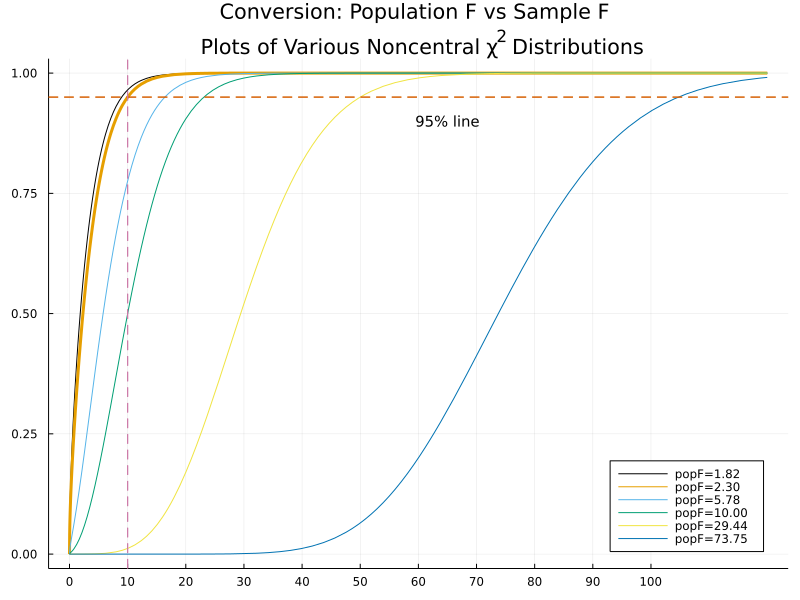

In [19]:
using Distributions

F1 = NoncentralChisq(1, 1.82)
F2 = NoncentralChisq(1, 2.30)
F3 = NoncentralChisq(1, 5.78)
F4 = NoncentralChisq(1,10.00)
F5 = NoncentralChisq(1,29.44)
F6 = NoncentralChisq(1,73.75)

plot(x -> cdf(F1, x), 0, 120, 
    legend = :bottomright, 
    label = "popF=1.82",
    size = (800, 600),
    xticks = 0:10:100,
    title = "Conversion: Population F vs Sample F \\n Plots of Various Noncentral \\chi^{2} Distributions")
plot!(x -> cdf(F2, x), label = "popF=2.30", lw=3)
plot!(x -> cdf(F3, x), label = "popF=5.78")
plot!(x -> cdf(F4, x), label = "popF=10.00")
plot!(x -> cdf(F5, x), label = "popF=29.44")
plot!(x -> cdf(F6, x), label = "popF=73.75")
hline!([0.95,0.95], linestyle=:dash, label=false)
vline!([10,10], linestyle=:dash, label=false)
annotate!(65, 0.90, text("95% line", 10))

How do we read the above picture?

Let's focus on the slightly thicker line for which population F is equal to 2.30. 

That line gives the cdf of the noncentral $\chi^2$ distribution with noncentrality parameter 2.30

In words: if the population $F$ is 2.30 then 95\% of sample $F$ should fall below 10

Contrapositive: if in an application you obtain a sample $F$ of at least 10, then it is unlikely that the underlying population $F$ was 2.30 (or lower)

This is a simple intuitive construction of a confidence interval for population $F$:

Your sample $F$ is 10 implies the confidence interval $F>2.30$ which in turn implies worst case empirical size at most 13.5%

Mapping from population F to sample F:

| Case | population F    | sample F    | Worst case empirical size (when $\rho=1$) |
|----|-------------------|-------------|-------------------------------------------|
| 1  | 1.82              | 8.96        | 15\% |
| 2  | 2.30              | 10.00       | 13.5\% |
| 3  | 5.78              | 16.38       | 10\% |
| 4  | 10.00             | 23.10       | 8.6\% |
| 5  | 29.44             | 50.00       | 6.4\% |
| 6  | 73.75             | 104.70      | 5.0\% |

Bottom line for practitioners:

If we want to be confident that the worst case empirical size will not exceed 15\%, then check that first stage (sample) F exceeds 8.96. 

(That's the origin of the *Rule of Thumb* that F exceed 10.)

The table also shows that if you strive for an empirical size of 5\% then need a sample F of 104.7.




## Is the Worst Case too Pessimistic?

Stock and Yogo's approach is to recommend a sufficiently high sample F to avoid empirical size problems under the worst case scenario when $\rho=1$. 

This is quite an unlikely case in practice. Here'a a back of the envelope calculation for a typical returns to schooling problem (taken from Keane & Neal):

* sample correlation between earnings and schooling is 0.45 (using data from the US Panel Study of Income Dynamics 2025)

* two effects can explain this correlation: 

  * direct causal effect of education on earnings

  * indirect effect of ability on earnings (via ability's correlation with education)

* that indirect effect is the source of endogeneity

* the largest magnitude the $\rho$ can be is 0.45, which would occur if the causal effect was zero

* we conclude that $\rho$ must be somewhere between 0 and 0.45

This suggests that the worst case scenario of $\rho=1$ might both be unrealistic and unnecessarily conservative!

Are we over-insuring ourselves by considering such an extreme scenario?

Quick check: Consider case 1, and plot empirical size against changing degree of endogeneity!

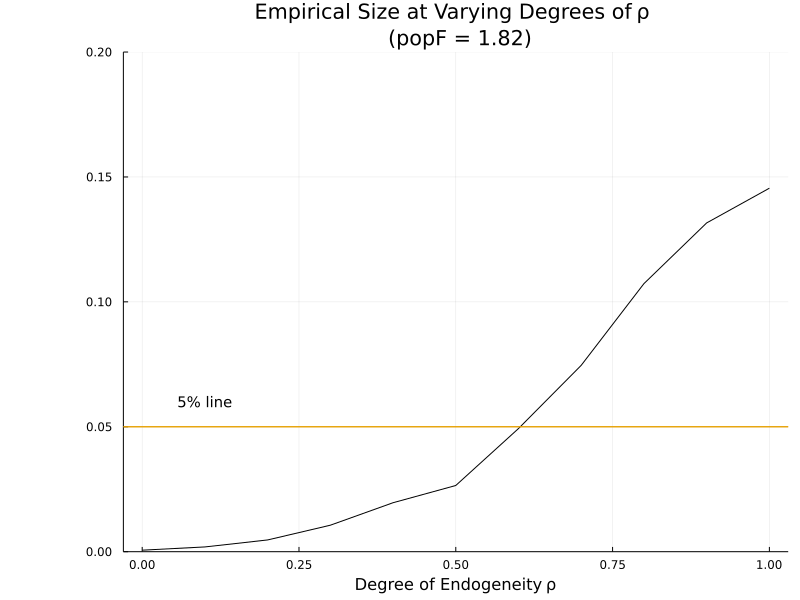

In [22]:
# replicating parts of Figure 1 of K&N 

using Plots
using Plots.PlotMeasures: mm

rho_range = 0:0.10:1
emp_size = [mean(abs.(simulate_distribution(F=1.82, rho=rho).tiv_dst .> 1.96)) for rho in rho_range]

plot(rho_range, emp_size, 
    legend=false, 
    xlab="Degree of Endogeneity \\rho", 
    left_margin=20mm,
    size=(800,600))
hline!([0.05, 0.05])
annotate!(.10, 0.06, text("5% line", 10))
ylims!(0,.20)
title!("Empirical Size at Varying Degrees of \\rho \\n (popF = 1.82)")

What do we learn here?

It looks like the worst case scenario of $\rho=1$ leads to a selectively bad result. 

More moderate degrees of endogeneity, say around $\rho=0.45$ (which might be more realistic in practice), are associated with good size properties!

On the other hand, very low degrees of endogeneity result in very low empirical size. 

(This may seem desirable, but in a way it shows us that we don't really know what's going on with our test.)